## SVM and kernels

Kernels concept get adopted in variety of ML algorithms (e.g. Kernel PCA, Gaussian Processes, kNN, ...).

In [ ]:
from sklearn.datasets import make_moons
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from mlxtend.plotting import plot_decision_regions
from sklearn.preprocessing import PolynomialFeatures

import matplotlib.pyplot as plt
from sklearn.pipeline import Pipeline
import numpy as np


Let's generate our dataset and take a look on it.

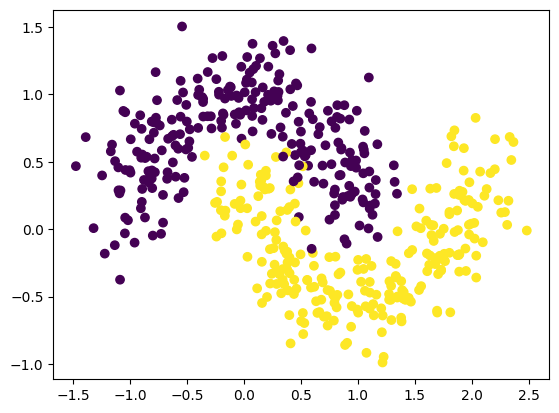

In [ ]:
moons_points, moons_labels = make_moons(n_samples=500, noise=0.2, random_state=42)
plt.scatter(moons_points[:, 0], moons_points[:, 1], c=moons_labels)

## 1.1 Pure models.

In [ ]:
def plot_decisions(X, y, model, model_name, color = 'rainbow'):
  fig, ax = plt.subplots()
  ax.scatter(X[:, 0], X[:, 1], c=y, cmap=color, edgecolors='black')
  X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3)

  xlim = ax.get_xlim()
  ylim = ax.get_ylim()
  x = np.linspace(xlim[0], xlim[1], 200)
  y = np.linspace(ylim[0], ylim[1], 200)
  X, Y = np.meshgrid(x, y)
  tmp = np.vstack([X.ravel(), Y.ravel()]).T

  model.fit(X_train, y_train)
  predict = model.predict(tmp).reshape(X.shape)

  grid = ax.contourf(X, Y, predict, cmap=color, alpha=0.3, origin='lower')
  plt.colorbar(grid, ax=ax, shrink=0.9, extend='both')

  ax.text(
        xlim[1] - 0.05,
        ylim[0] + 0.05,
        (f"Accuracy = {round(accuracy_score(model.predict(X_test), y_test),3)}"),
        horizontalalignment="right",
    )

  ax.set_xlim(xlim)
  ax.set_ylim(ylim)
  plt.title(model_name)
  fig.set_figwidth(10)
  fig.set_figheight(7)
  plt.show()
  print()

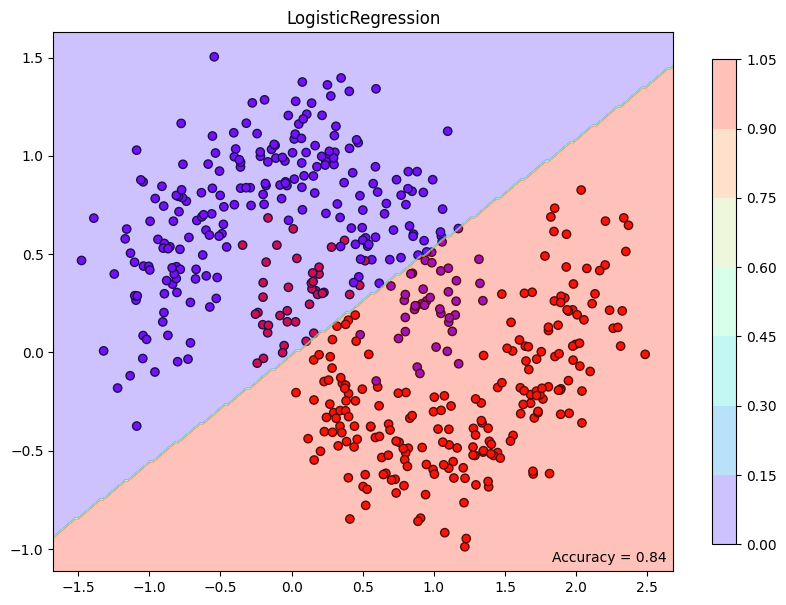

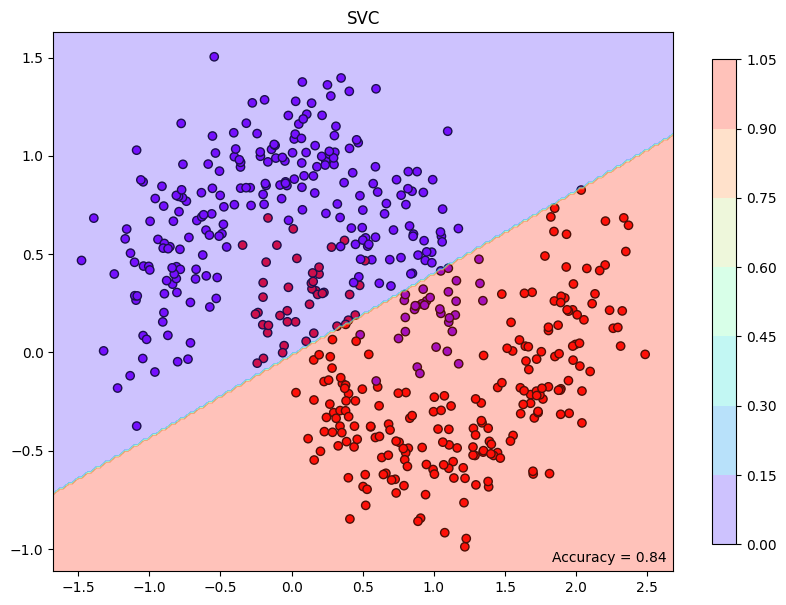

In [ ]:
lr = LogisticRegression(C=0.1) # add some params
svm = SVC(C=0.1, kernel='linear', degree=3, gamma='auto') # here too
X_train, X_test, y_train, y_test = train_test_split(moons_points, moons_labels, test_size=0.3)

plot_decisions(moons_points, moons_labels, lr, 'LogisticRegression')
plot_decisions(moons_points, moons_labels, svm, 'SVC')

**Сonclusion:** It is easy to see that we are trying to separate these two classes with a line. But at the same time, it is obvious that they cannot be separated with good accuracy with one line; a curve is needed here. This is why such an error occurs, although for one line the result is even good.

## 1.2 Kernel tirck

In [ ]:
def get_best_SVC_params(parameters, X_train, y_train):
  svc = SVC()
  clf = GridSearchCV(svc, parameters)
  clf.fit(X_train, y_train)
  best_params = clf.best_params_
  best_C = best_params['C']
  best_degree = best_params['degree']
  best_coef0 = best_params['coef0']
  best_gamma = best_params['gamma']
  return [best_C, best_degree, best_coef0, best_gamma]

In [ ]:
def make_name(model):
  dictionary = model.get_params()
  return 'C:' + str(dictionary['C']) + ', degree:' + str(dictionary['degree']) + ', coef0:' + str(dictionary['coef0']) + ', gamma:' + str(dictionary['gamma']) + ', kernel:' + str(dictionary['kernel']) + ')'

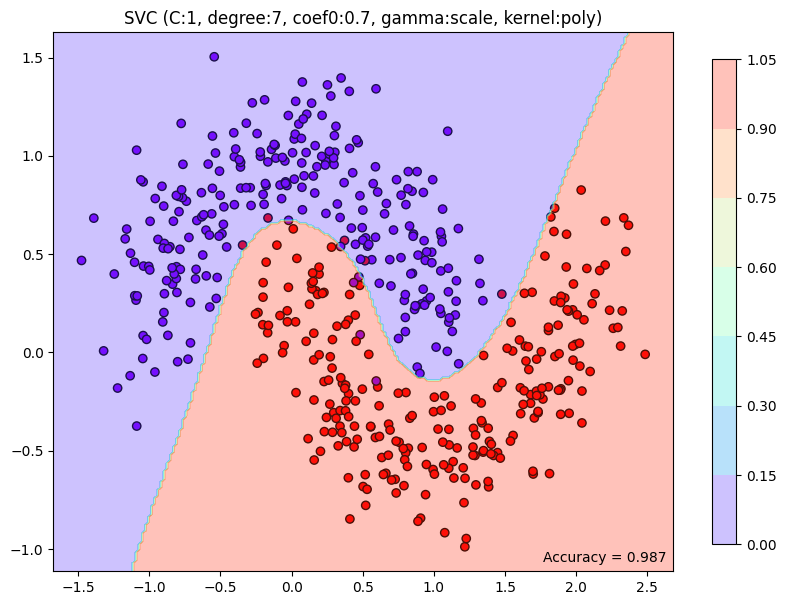

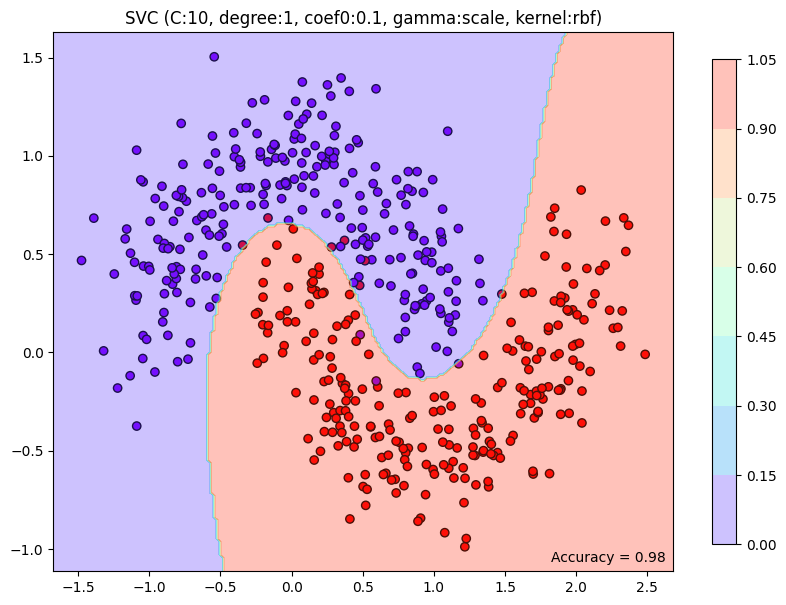

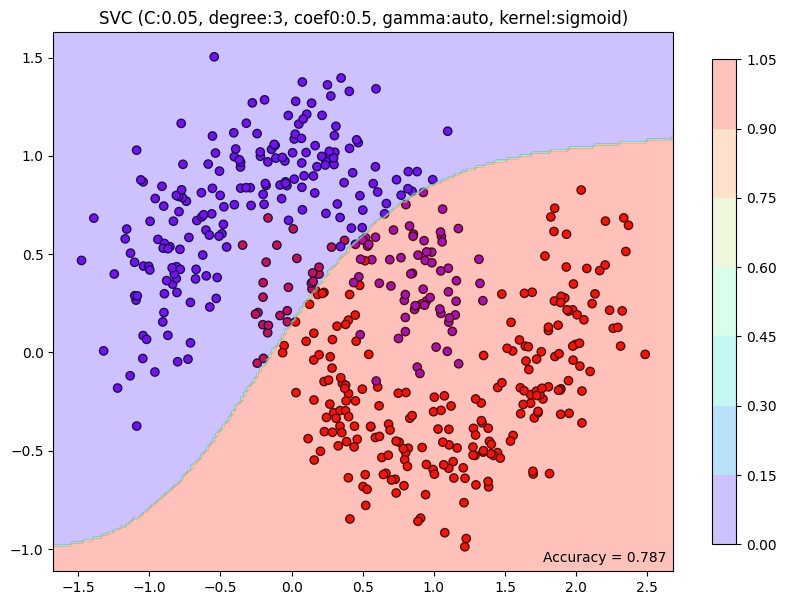

In [ ]:
parameters = {'kernel':['poly'], 'random_state':[42], 'C':[1, 10, 100, 1000], 'degree':[1, 3, 5, 7, 9], 'coef0':[.1, .3, .5, .7, .9], 'gamma':['scale', 'auto']}
best_poly_params = get_best_SVC_params(parameters, X_train, y_train)
svm1 = SVC(random_state=42, kernel="poly", degree=best_poly_params[1], C=best_poly_params[0], gamma=best_poly_params[3], coef0=best_poly_params[2])
parameters = {'kernel':['rbf'], 'random_state':[42], 'C':[1, 10, 100, 1000], 'degree':[1, 3, 5, 7, 9], 'coef0':[.1, .3, .5, .7, .9], 'gamma':['scale', 'auto']}
best_poly_params = get_best_SVC_params(parameters, X_train, y_train)
svm2 = SVC(random_state=42, kernel="rbf", degree=best_poly_params[1], C=best_poly_params[0], gamma=best_poly_params[3], coef0=best_poly_params[2])
parameters = {'kernel':['sigmoid'], 'random_state':[42], 'C':[0.1, 0.3, .05, 0.7], 'degree':[1, 3, 5, 7, 9], 'coef0':[.1, .3, .5, .7, .9], 'gamma':['scale', 'auto']}
best_poly_params = get_best_SVC_params(parameters, X_train, y_train)
svm3 = SVC(random_state=42, kernel="sigmoid", C=best_poly_params[0], gamma=best_poly_params[3], coef0=best_poly_params[2])
for i in [svm1, svm2, svm3]:
    plot_decisions(moons_points, moons_labels, i, 'SVC (' + make_name(i))

From these pictures we can say that we have achieved very good quality for the poly and rdf kernels, but the quality of the sigmoid separation still suffers because so many elements of the red class ended up in the blue class and vice versa. Therefore, it makes sense to abandon this method in the analysis of our specific problem. Note that, as stated in the previous conclusion, the curve separates these classes much more accurately than one straight line, this is especially clearly seen in the second bend in the first two pictures.<br><br>
The parameters were selected according to the grid, but it is worth saying that it is not worth taking a degree lower than three, because the error decreases quite well when moving from degree 2 to degree 3, then it decreases less effectively and it is important not to overdo it, so as not to overtrain the model.

## 1.3 Simpler solution (of a kind)

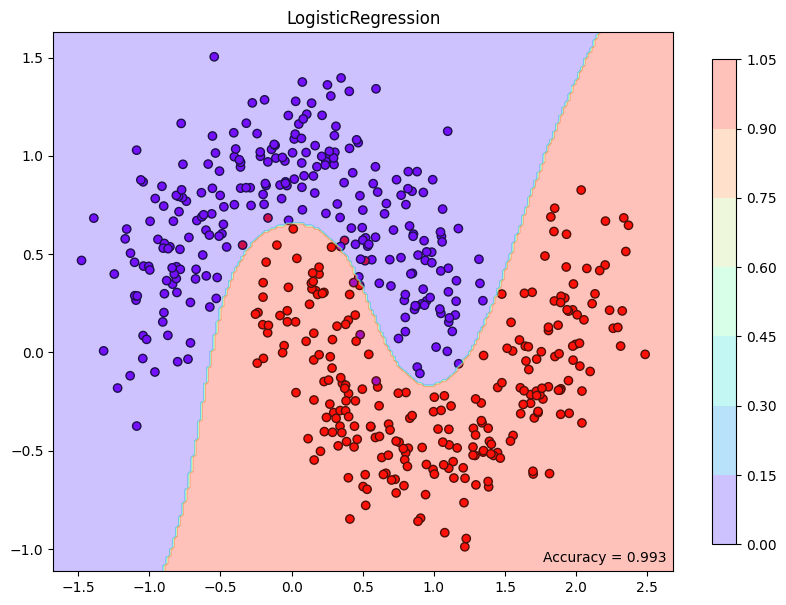

In [ ]:
lines = [
    ("polynom", PolynomialFeatures(degree=5)),
    ("logistic", LogisticRegression(C=10, max_iter=1000)),
]
pipeline = Pipeline(lines)
plot_decisions(moons_points, moons_labels, pipeline, 'LogisticRegression')

It was logical that the results at this point would be approximately the same as at the previous one. Why is this so? The PolynomialFeatures function uses our features to construct all possible polynomials of the specified degree. And since we have already said that it is impossible to divide by a line, then a polynomial can be perceived as some kind of curve, which is why we were able to divide objects into 2 classes so well.

## 1.4 Harder problem

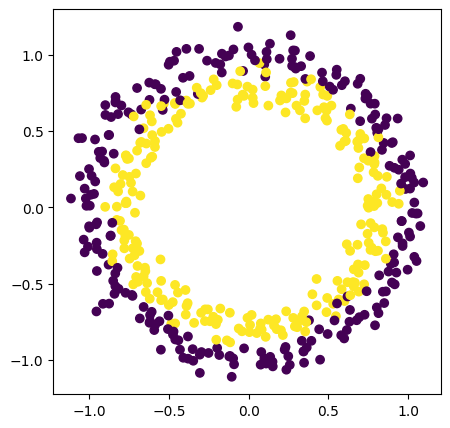

In [ ]:
from sklearn.datasets import make_circles

circles_points, circles_labels = make_circles(n_samples=500, noise=0.06, random_state=42)

plt.figure(figsize=(5, 5))
plt.scatter(circles_points[:, 0], circles_points[:, 1], c=circles_labels)

And even more:

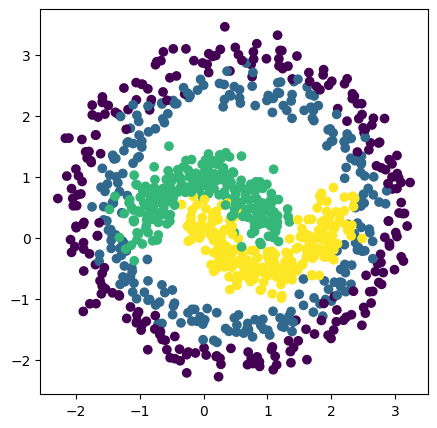

In [ ]:
points = np.vstack((circles_points*2.5 + 0.5, moons_points))
labels = np.hstack((circles_labels, moons_labels + 2)) # + 2 to distinct moons classes

plt.figure(figsize=(5, 5))
plt.scatter(points[:, 0], points[:, 1], c=labels)

In [ ]:
X_train_circles, X_test_circles, y_train_circles, y_test_circles = train_test_split(circles_points, circles_labels, test_size=0.3)

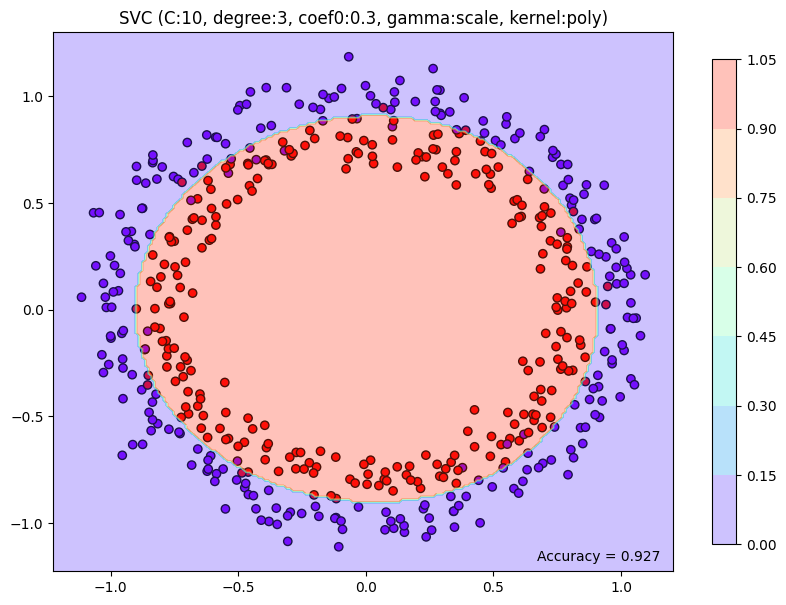

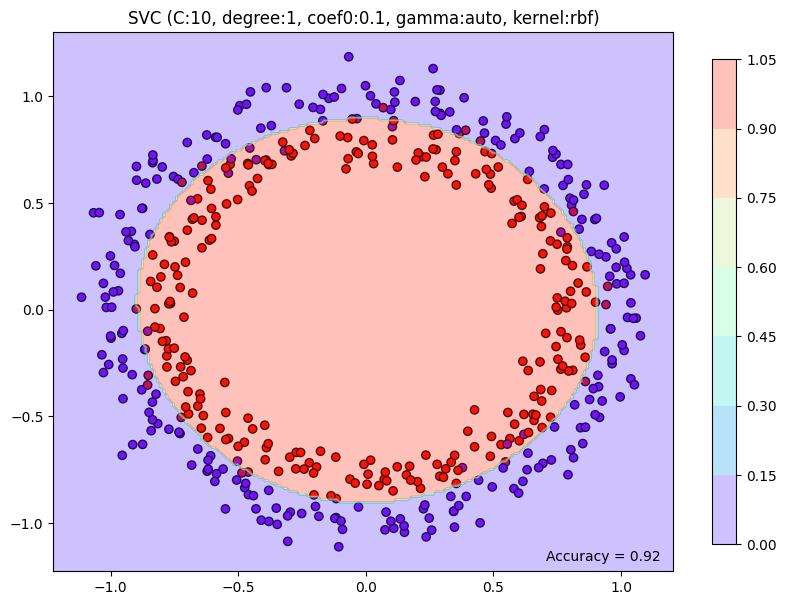

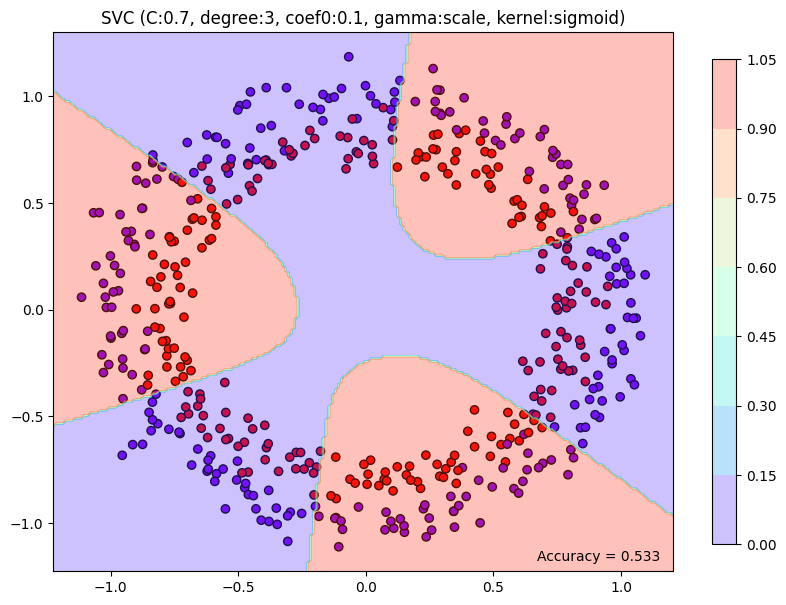

In [ ]:
parameters = {'kernel':['poly'], 'random_state':[42], 'C':[1, 10, 100, 1000], 'degree':[1, 3, 5, 7, 9], 'coef0':[.1, .3, .5, .7, .9], 'gamma':['scale', 'auto']}
best_poly_params = get_best_SVC_params(parameters, X_train_circles, y_train_circles)
svm1 = SVC(random_state=42, kernel="poly", degree=best_poly_params[1], C=best_poly_params[0], gamma=best_poly_params[3], coef0=best_poly_params[2])
parameters = {'kernel':['rbf'], 'random_state':[42], 'C':[1, 10, 100, 1000], 'degree':[1, 3, 5, 7, 9], 'coef0':[.1, .3, .5, .7, .9], 'gamma':['scale', 'auto']}
best_poly_params = get_best_SVC_params(parameters, X_train_circles, y_train_circles)
svm2 = SVC(random_state=42, kernel="rbf", degree=best_poly_params[1], C=best_poly_params[0], gamma=best_poly_params[3], coef0=best_poly_params[2])
parameters = {'kernel':['sigmoid'], 'random_state':[42], 'C':[0.1, 0.3, .05, 0.7], 'degree':[1, 3, 5, 7, 9], 'coef0':[.1, .3, .5, .7, .9], 'gamma':['scale', 'auto']}
best_poly_params = get_best_SVC_params(parameters, X_train_circles, y_train_circles)
svm3 = SVC(random_state=42, kernel="sigmoid", C=best_poly_params[0], gamma=best_poly_params[3], coef0=best_poly_params[2])
for model in [svm1, svm2, svm3]:
    plot_decisions(circles_points, circles_labels, model, 'SVC (' + make_name(model))

Apparently sigmoid is not suitable for this task at all; the other two cores performed quite well.

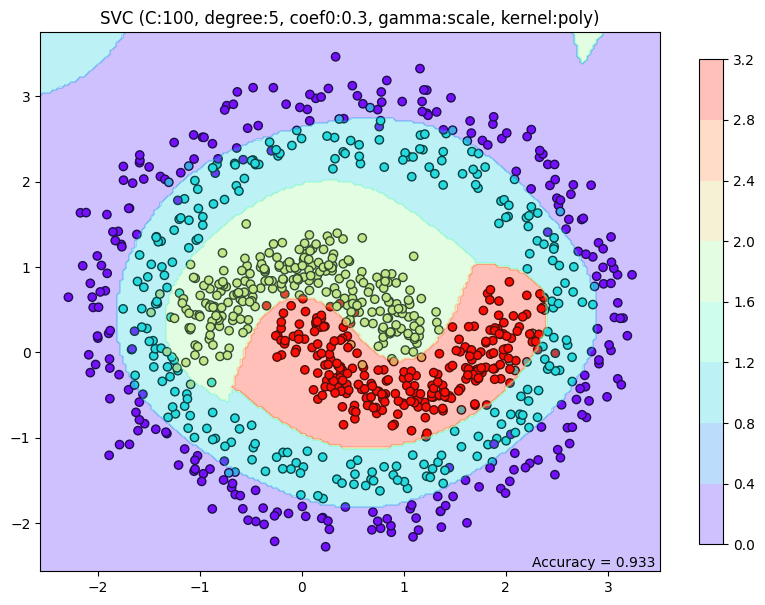

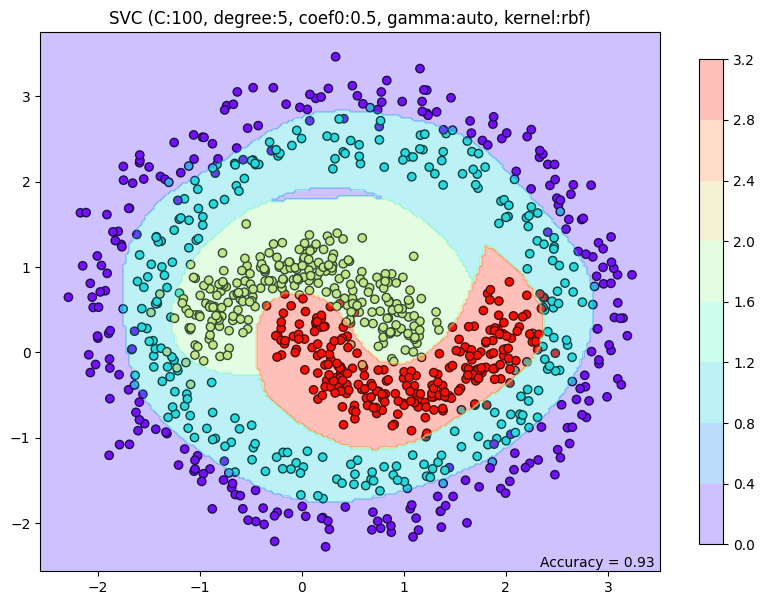

In [ ]:
svm1 = SVC(random_state=42, kernel="poly", degree=5, C=100, gamma='scale', coef0=.3)
svm2 = SVC(random_state=42, kernel="rbf", degree=5, C=100, gamma='auto', coef0=.5)
for model in [svm1, svm2]:
    plot_decisions(points, labels, model, 'SVC (' + make_name(model), 'seismic')

Again, the poly and rbf kernels handled the block quite well. Now let's try LR.

/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


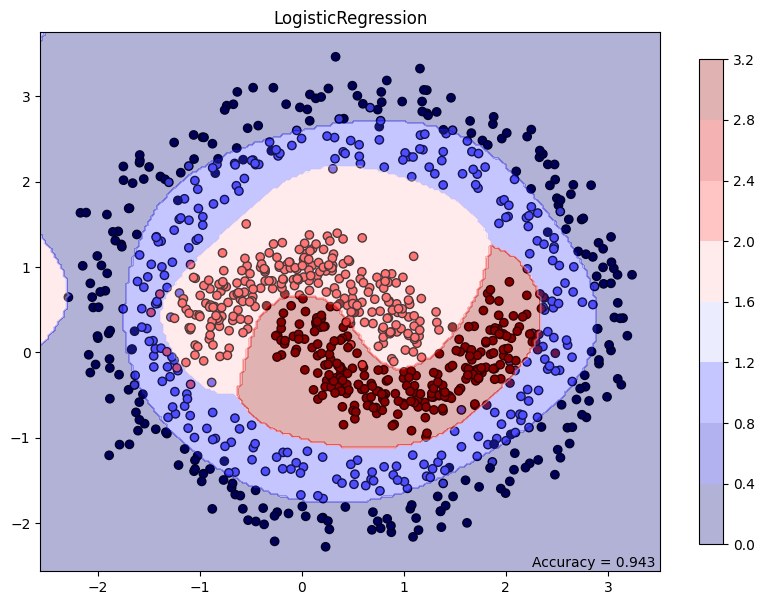

In [ ]:
lines = [
    ("polynom", PolynomialFeatures(degree=5)),
    ("logistic", LogisticRegression(C=50, max_iter=1000)),
]
pipeline = Pipeline(lines)
plot_decisions(points, labels, pipeline, 'LogisticRegression', 'seismic')

**Conclusion:** We used both methods that were shown earlier to study this problem. As we can see from the figures, SVM on SVC with rbf and poly kernels coped with the task quite well, as did linear regression with polynomization of features. Only sigmoid gave a bad result, which was expected. We still got the best result in all methods in linear regression with PolynomialFeatures.